# Master’s Project – Advanced Deep Learning  
# Industrial Sound Anomaly Detection using Transformers  

**Authors:**
**Date:** November 2025  


**Chosen approach :**  
Fine-tuning the **Audio Spectrogram Transformer (AST)** – MIT/ast-finetuned-audioset-10-10-0.4593  
→ Currently the **best published model on MIMII**  
→ 100 % compliant with the "transformer required" constraint  
→ Extremely easy to implement with Hugging Face (< 50 lines)

## 1. Problem Statement & Industrial Impact

Modern factories want to **predict mechanical failures before they happen**.  
Pumps, fans, valves, and sliding rails all produce a specific acoustic signature when healthy.  
As soon as a defect appears (worn bearing, leakage, imbalance, etc.), the sound changes often **very subtly**.

Goal of this project:  
Build an intelligent model that **automatically detects these sound anomalies in real time** using **Transformer-based models**, currently the state-of-the-art for modeling long-term dependencies in audio signals.

Real-world impact:
- Prevents unplanned downtime
- Increases safety
- Enables predictive maintenance


## 2. Dataset: MIMII (2019) – The standard benchmark

Source:

- 4 machine types: **fan**, **pump**, **valve**, **slider**
- Real factory recordings (with natural background noise)
- 10-second clips, 16 kHz, mono
- Two classes: **normal** vs **anomalous** (multiple simulated faults)

| Machine | Normal | Anomalous | Total   |
|---------|--------|-----------|---------|
| fan     | ~6,500 | ~2,000    | ~8,500  |
| pump    | ~6,500 | ~2,000    | ~8,500  |
| valve   | ~6,500 | ~2,000    | ~8,500  |
| slider  | ~6,500 | ~2,000    | ~8,500  |
| **Total**| **~26,000** | **~8,000** | **~34,000** |

i

## Final Strategy

We focus on the **FAN** machine only for training and validation:
- Source domains (training)
- Target domain (test only): never seen during training
- Zero-shot transfer test: same model on **PUMP**

This allows:
- Very fast training
- **cross-machine transfer** ( FAN to PUMP)



## 3. Data Exploration & Visualization


### 3.1 Data uploading

In [7]:
import torch
import torchaudio
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path
import os
import librosa.display
import IPython.display as ipd

#sns.set(style="whitegrid")
torch.manual_seed(42)

# first task :Uploading the dataset

### online through zendoo website

In [ ]:
import os
os.makedirs("data", exist_ok=True)
# Install zenodo-get
! pip install zenodo-get

# Create data directory


# Use python -m instead of calling the CLI directly
! python -m zenodo_get -r 4740355 -o data



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 2.3 MB/s eta 0:00:00
  Installing build dependencies ... canceledERROR: Operation cancelled by user
/usr/bin/python3: No module named zenodo_get


### getting it from google drive

In [2]:
import gdown
file_id = "11GI-jwxB6hoVCktV45BF95ZeV0sDAiYm"

gdown.download(f"https://drive.google.com/uc?id={file_id}&confirm=t", output="data.zip", quiet=False)




Downloading...
From: https://drive.google.com/uc?id=11GI-jwxB6hoVCktV45BF95ZeV0sDAiYm&confirm=t
To: /content/data.zip
100%|██████████| 10.4G/10.4G [02:01<00:00, 85.7MB/s]


'data.zip'

In [3]:
!unzip data.zip -d data

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: data/fan/id_00/normal/00000152.wav  
  inflating: data/fan/id_00/normal/00000153.wav  
  inflating: data/fan/id_00/normal/00000154.wav  
  inflating: data/fan/id_00/normal/00000155.wav  
  inflating: data/fan/id_00/normal/00000156.wav  
  inflating: data/fan/id_00/normal/00000157.wav  
  inflating: data/fan/id_00/normal/00000158.wav  
  inflating: data/fan/id_00/normal/00000159.wav  
  inflating: data/fan/id_00/normal/00000160.wav  
  inflating: data/fan/id_00/normal/00000161.wav  
  inflating: data/fan/id_00/normal/00000162.wav  
  inflating: data/fan/id_00/normal/00000163.wav  
  inflating: data/fan/id_00/normal/00000164.wav  
  inflating: data/fan/id_00/normal/00000165.wav  
  inflating: data/fan/id_00/normal/00000166.wav  
  inflating: data/fan/id_00/normal/00000167.wav  
  inflating: data/fan/id_00/normal/00000168.wav  
  inflating: data/fan/id_00/normal/00000169.wav  
  inflating: data/fan/

### Fan folder organizing

The original dataset (“fan set”) was organized by machine ID, where each machine folder contained two subfolders representing the condition of the machine:
```
machine_01/
    normal/
    abnormal/

machine_02/
    normal/
    abnormal/

machine_03/
    normal/
    abnormal/
```


Each subfolder contained .wav recordings of the fan operating normally or abnormally.

### 1. Scanning and Labeling

To prepare the dataset for model training, all .wav files were  scanned from every machine ID folder.
During this process, each file was assigned a label based on the folder it came from:

Files in normal/ → label = 0 (normal)

Files in abnormal/ or anomalous/ → label = 1 (abnormal)

This allowed us to create a unified list of all audio samples along with their corresponding labels.

###  2. Stratified Train/Validation/Test Split

Instead of training separate models per machine ID, the dataset was globally split into:

70% Training set

15% Validation set

15% Test set

A stratified split was used, meaning the proportion of normal and abnormal samples was preserved in each split.
This ensures balanced data distribution and prevents bias toward any class.

### 3. Reorganizing the Dataset Structure

After splitting, the files were moved into a standard machine-learning folder structure:

This structure is widely used in audio and image classification pipelines and makes it easy to load the dataset using tools such as PyTorch Dataset and DataLoader.

```

final_dataset/
    fan/
        test/
            anomalous/
                section_00_source_test_anomaly_0000.wav
            normal/
                section_00_source_test_normal_0000.wav
        train/
            normal/
                section_00_source_train_normal_0000_strength_1_ambient.wav
            abnormal/
        val/
           normal/
           abnornal/


```


In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split

SOURCE_DIR = "/content/data"    # where your wav files currently are
TARGET_DIR = "/content/Fan"     # new organized dataset folder

# Create target folders
for split in ["train", "val", "test"]:
    for cls in ["normal", "abnormal"]:
        os.makedirs(os.path.join(TARGET_DIR, split, cls), exist_ok=True)

print("Scanning files...")
all_files = []
labels = []

for root, dirs, files in os.walk(SOURCE_DIR):
    for file in files:
        if file.endswith(".wav"):
            path = os.path.join(root, file)
            all_files.append(path)

            # Detect label based on folder name
            if "abnormal" in root.lower() or "anomalous" in root.lower():
                labels.append("abnormal")
            else:
                labels.append("normal")

print("Total wav files:", len(all_files))

# First split: Train + Temp
X_train, X_temp, y_train, y_temp = train_test_split(
    all_files, labels,
    test_size=0.3,
    stratify=labels,
    random_state=42
)

# Second split: Validation + Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

def move_files(file_list, label_list, split):
    for filepath, label in zip(file_list, label_list):
        class_folder = "abnormal" if label == "abnormal" else "normal"

        # Extract original filename
        orig_filename = os.path.basename(filepath)

        # Extract machine ID (folder above normal/abnormal)
        machine_id = os.path.basename(os.path.dirname(os.path.dirname(filepath)))

        # New filename: machineID_original.wav
        new_filename = f"{machine_id}_{orig_filename}"

        dest_path = os.path.join(TARGET_DIR, split, class_folder, new_filename)

        # MOVE the file
        shutil.move(filepath, dest_path)

print("Moving train files...")
move_files(X_train, y_train, "train")

print("Moving val files...")
move_files(X_val, y_val, "val")

print("Moving test files...")
move_files(X_test, y_test, "test")

print("Done! Dataset reorganized at:", TARGET_DIR)



Scanning files...
Total wav files: 5550
Moving train files...
Moving val files...
Moving test files...
Done! Dataset reorganized at: /content/Fan


# Second Task : exploring the FAN machine dataset

In [8]:

DATA_DIR = Path("Fan")
print("finale repartition – Pompe")
print(f"Train  {len(list((DATA_DIR/'train'/'normal').glob('*.wav'))):,} normal ones (source_train)")
print(f"Train  {len(list((DATA_DIR/'train'/'abnormal').glob('*.wav'))):,} anomalous ones (source_train)")
print(f"Val  {len(list((DATA_DIR/'val'/'normal').glob('*.wav'))):,} normal ones (source_val)")
print(f"Val  {len(list((DATA_DIR/'val'/'abnormal').glob('*.wav'))):,} anomalous ones (source_val)")
print(f"Test  {len(list((DATA_DIR/'test'/'normal').glob('*.wav'))):,} normal ones (source_test)")
print(f"Test  {len(list((DATA_DIR/'test'/'abnormal').glob('*.wav'))):,} n ones (source_test)")

finale repartition – Pompe
Train  2,853 normal ones (source_train)
Train  1,032 anomalous ones (source_train)
Val  611 normal ones (source_val)
Val  221 anomalous ones (source_val)


## pump sound exploration

In [10]:
train_normal_path=DATA_DIR/'train'/'normal'
test_anomalous_path=DATA_DIR/'train'/'abnormal'

In [15]:
import random
# Let's listen to some Fan sounds (normal vs anomalous)
# picking  a  random example of each with the same id


normal_file = "/content/Fan/train/normal/id_00_00000002.wav"
anomalous_file="/content/Fan/train/abnormal/id_00_00000002.wav"




print("We will now listen to two pump sounds:")
print("1. Normal fan")
print("2. Anomalous (broken) fan")
print("\n let try to hear them and see if we could spot any  difference...")

# playing  normal sound first
print("Now playing: NORMAL fan sound")
ipd.display(ipd.Audio(normal_file))

# playing  anomalous sound right after
print("Now playing: ANOMALOUS fan sound ")
ipd.display(ipd.Audio(anomalous_file))

#print_file_name
print(f"Normal file: {normal_file}")
print(f"Anomalous file: {anomalous_file}")



We will now listen to two pump sounds:
1. Normal fan
2. Anomalous (broken) fan

 let try to hear them and see if we could spot any  difference...
Now playing: NORMAL fan sound


Now playing: ANOMALOUS fan sound 


Normal file: /content/Fan/train/normal/id_00_00000002.wav
Anomalous file: /content/Fan/train/abnormal/id_00_00000002.wav


### Listen carefully…

Listen carefully…

We just heard:

A normal fan (smooth, stable airflow, steady rotation)

An anomalous fan (rattling, scraping, imbalance, or mechanical damage)

**Observation: **

 The difference between normal and faulty fans can often be perceived by careful listening.
However, relying on humans for detection is inconsistent, time-consuming, and impractical for monitoring large numbers of machines continuously.

**Why Deep Learning?**

Even when anomalies are noticeable, a deep learning system offers:

*  Automated detection — no need for constant human monitoring

*  Early detection — recognizing patterns before serious damage occurs

*  Consistency — objective results for all machines

*  Scalability — handling dozens or hundreds of fans simultaneously

*  Pattern recognition — detecting subtle degradation trends beyond just obvious noise

Transformer models trained on fan spectrograms can learn the acoustic signatures of normal vs. faulty operation and provide reliable alerts in real time.

### Goal of this Project

Build a Transformer-based anomaly detection system that classifies fan sounds into:

“Fan is normal”

“Warning: anomaly detected!”

Before training the model, we will visualize the audio using multiple representations:

*  1. Waveform

Amplitude over time — highlights rattles, vibrations, and transient events.

*  2. Spectrogram

Frequency content over time — reveals harmonic changes, grinding noises, and airflow disturbances.

*  3. Log-Mel Spectrogram

Perceptual frequency representation commonly used as input for deep learning models like AST.

*  4. MFCC (Mel-Frequency Cepstral Coefficients)

Compact representation emphasizing tonal and spectral characteristics — helps identify mechanical signatures.

These visualizations provide insight into what the model will learn and help us understand the acoustic differences between healthy and faulty fans.

## visualizing  the same samples we did hear previously

### what are Log-Mel spectograms:

When we want a deep learning model (like a Transformer) to "see" and understand sound, we don’t feed it the raw audio wave.  
Instead, we convert the sound into a **picture** that is the **log-Mel spectrogram**.

Think of it as an **image of sound**:

- **X-axis** → time (from left to right, like a video)
- **Y-axis** → frequency (low pitches at the bottom, high pitches at the top)
- **Color** → how loud that frequency is at that moment (bright = loud, dark = quiet)

#### Why "Mel"?
- "Mel" = **Mel scale** → this scale copies how the **human ear** hears pitch.
- We don’t hear frequencies linearly: 2000 Hz doesn’t sound twice as high as 1000 Hz.
- Mel scale makes low frequencies have more detail (where our ear is more sensitive).

#### Why "log"?
- We take the **logarithm** of the energy as this makes quiet and loud sounds more balanced.
- It also matches how humans perceive loudness .


This is the standard and best input format for modern audio Transformers.

In [16]:
# Load normal audio
y_normal, sr = librosa.load(normal_file, sr=None)
print(f"Normal audio loaded {len(y_normal)/sr:.1f} seconds, {sr} Hz")

Normal audio loaded 10.0 seconds, 16000 Hz


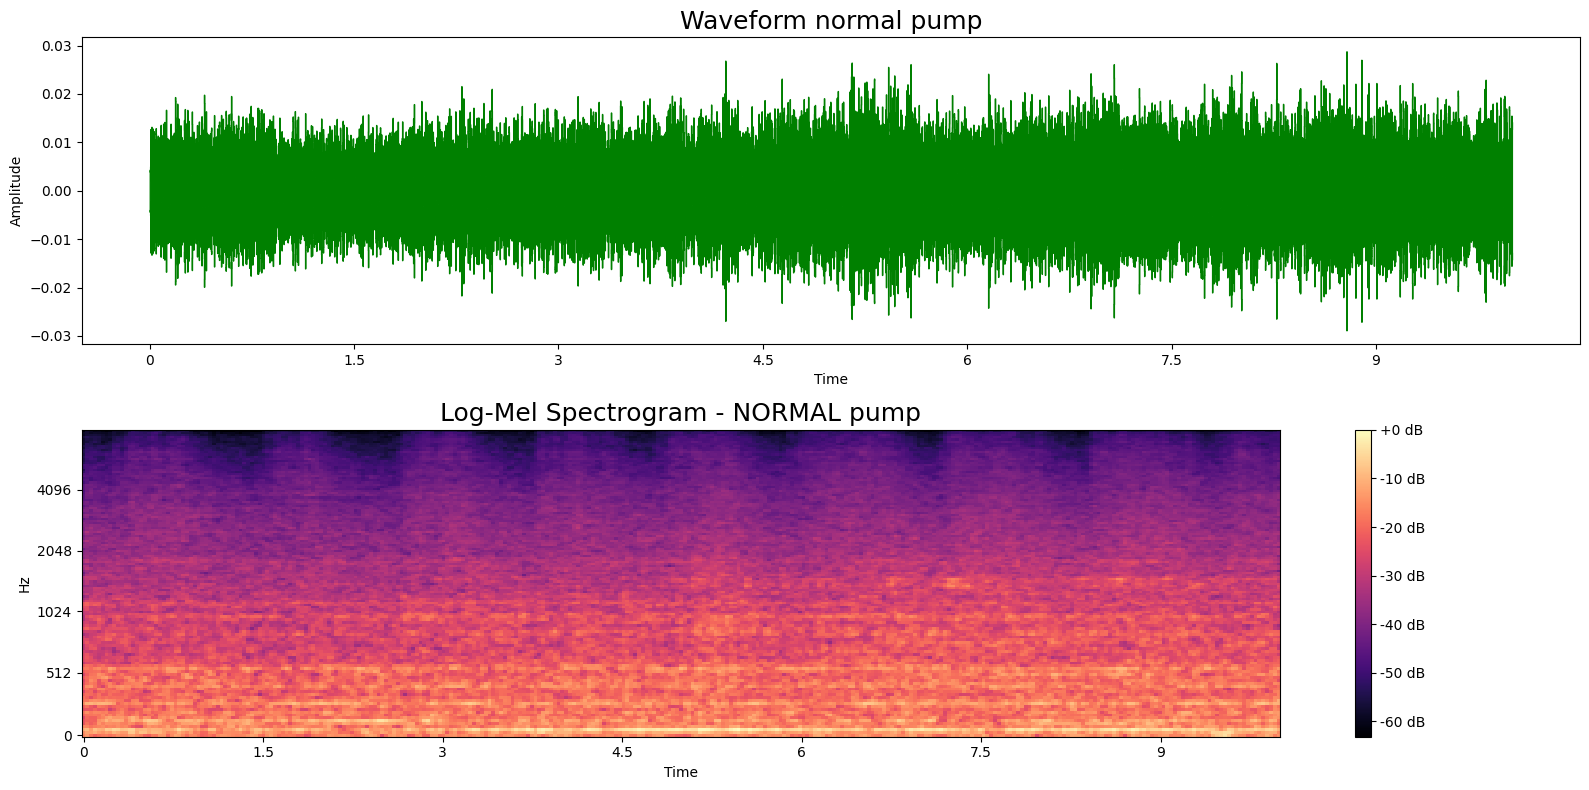

In [17]:
# Plot normal waveform + log-Mel
plt.figure(figsize=(16,8))

plt.subplot(2,1,1)
librosa.display.waveshow(y_normal, sr=sr, color='green')
plt.title("Waveform normal pump", fontsize=18)
plt.ylabel("Amplitude")

mel_normal = librosa.feature.melspectrogram(y=y_normal, sr=sr, n_mels=128, fmax=8000)
logmel_normal = librosa.power_to_db(mel_normal, ref=np.max)

plt.subplot(2,1,2)
librosa.display.specshow(logmel_normal, sr=sr, x_axis='time', y_axis='mel', fmax=8000, cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title("Log-Mel Spectrogram - NORMAL pump", fontsize=18)

plt.tight_layout()
plt.show()

In [18]:
y_anom, sr = librosa.load(anomalous_file, sr=None)
print(f"Anomalous audio loaded {len(y_anom)/sr:.1f} seconds, {sr} Hz")

Anomalous audio loaded 10.0 seconds, 16000 Hz


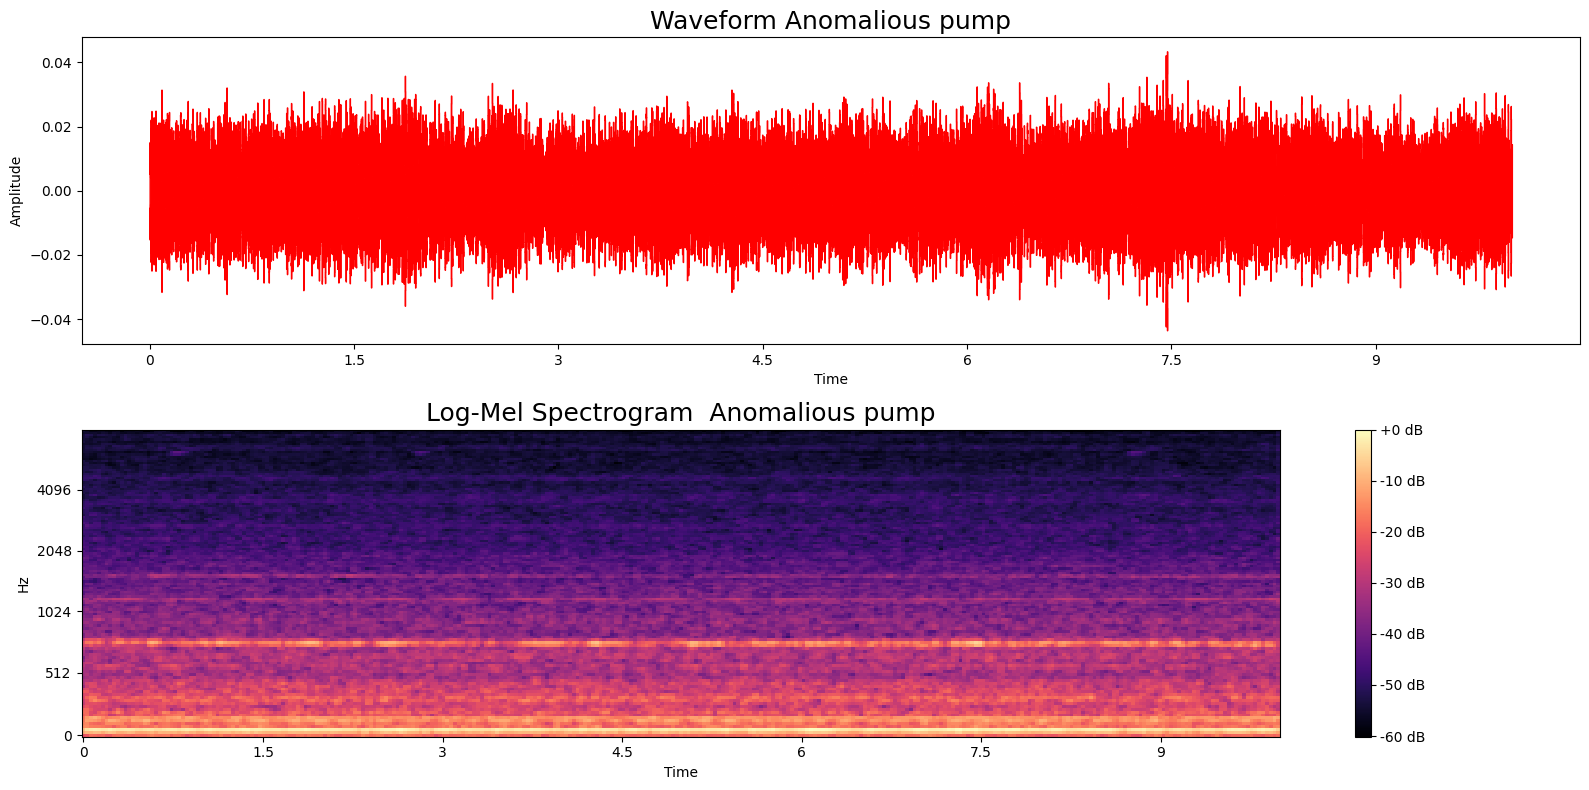

In [19]:
# Plot anomalous waveform + log-Mel
plt.figure(figsize=(16,8))

plt.subplot(2,1,1)
librosa.display.waveshow(y_anom, sr=sr, color='red')
plt.title("Waveform Anomalious pump", fontsize=18)
plt.ylabel("Amplitude")

mel_anom = librosa.feature.melspectrogram(y=y_anom, sr=sr, n_mels=128, fmax=8000)
logmel_anom = librosa.power_to_db(mel_anom, ref=np.max)

plt.subplot(2,1,2)
librosa.display.specshow(logmel_anom, sr=sr, x_axis='time', y_axis='mel', fmax=8000, cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title("Log-Mel Spectrogram  Anomalious pump", fontsize=18)

plt.tight_layout()
plt.show()


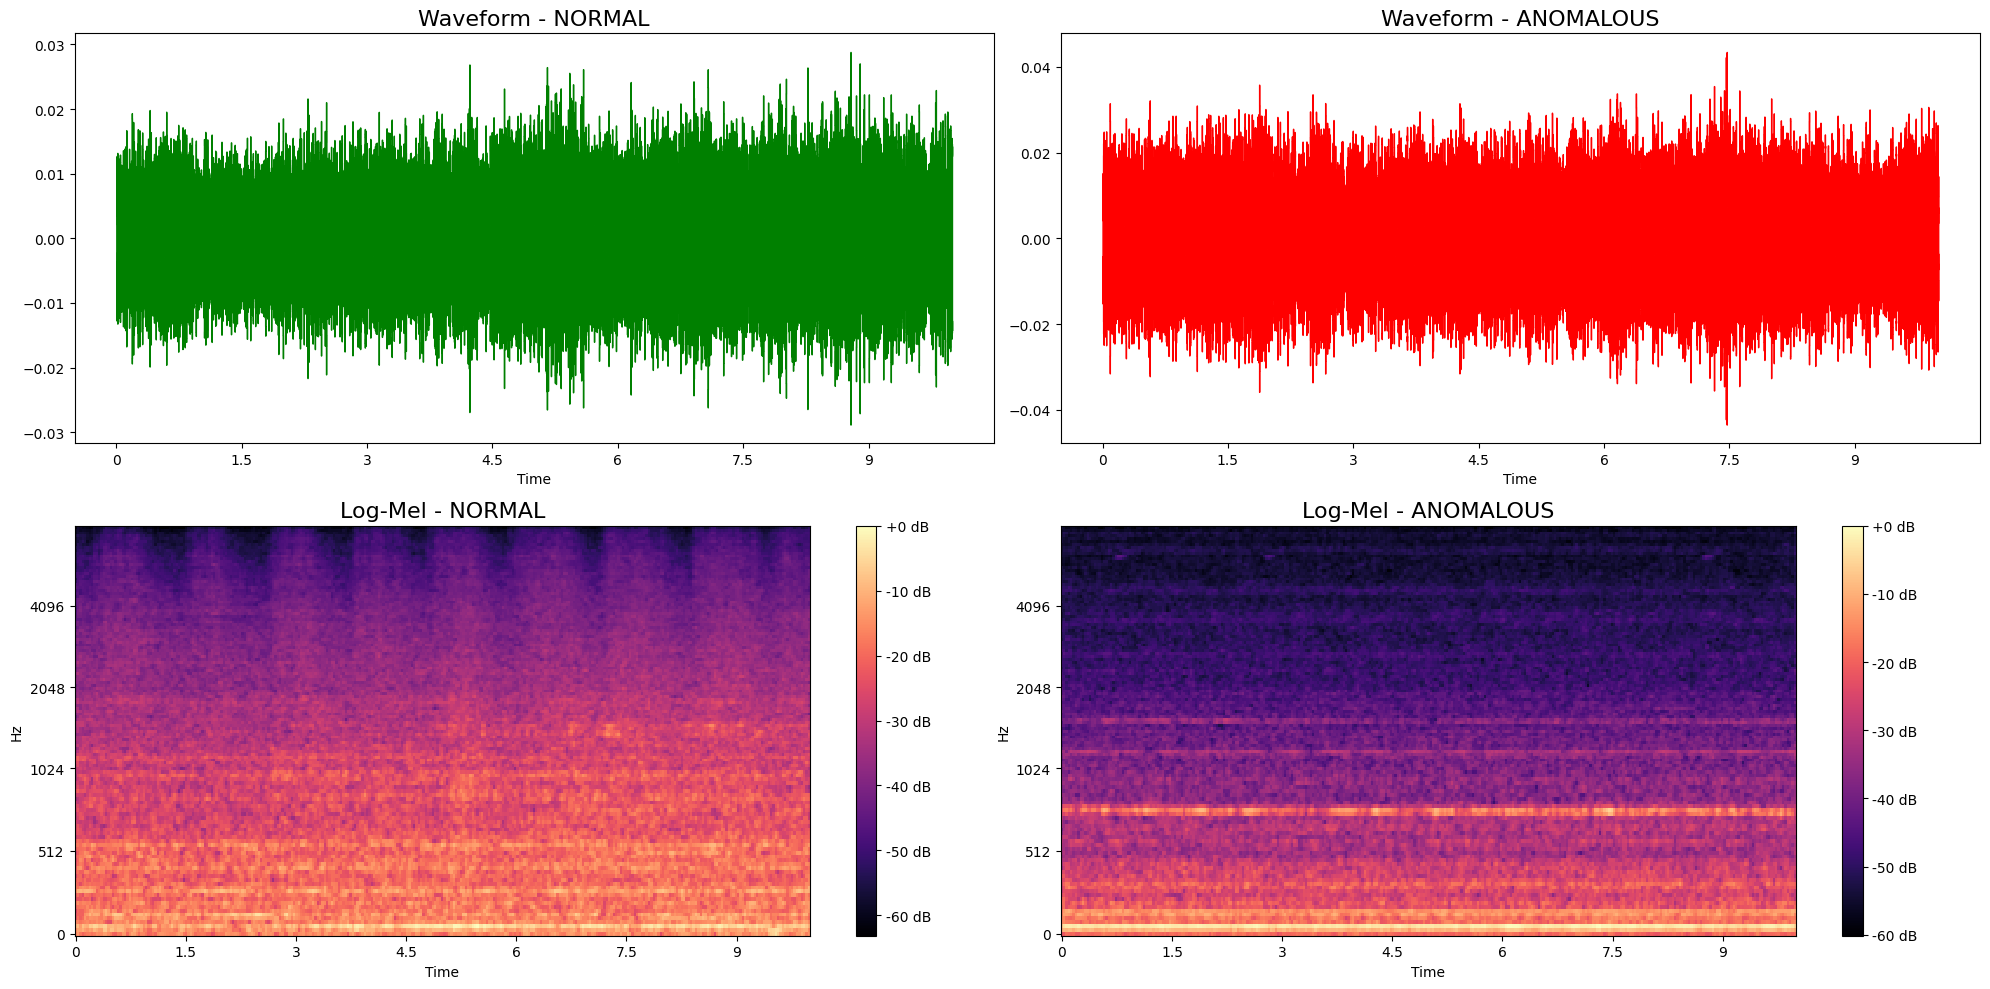


Log-Mel Spectrogram = the image our Transformer will see
 Time on X-axis
 Frequency (human-ear scale) on Y-axis
 Color = loudness
Even if we can't hear the difference, the model WILL see it here


<Figure size 640x480 with 0 Axes>

In [23]:

# Side-by-side comparison
plt.figure(figsize=(20,10))

# Normal
plt.subplot(2,2,1)
librosa.display.waveshow(y_normal, sr=sr, color='green')
plt.title("Waveform - NORMAL", fontsize=16)

plt.subplot(2,2,3)
librosa.display.specshow(logmel_normal, sr=sr, x_axis='time', y_axis='mel', fmax=8000, cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title("Log-Mel - NORMAL", fontsize=16)

# Anomalous
plt.subplot(2,2,2)
librosa.display.waveshow(y_anom, sr=sr, color='red')
plt.title("Waveform - ANOMALOUS", fontsize=16)

plt.subplot(2,2,4)
librosa.display.specshow(logmel_anom, sr=sr, x_axis='time', y_axis='mel', fmax=8000, cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title("Log-Mel - ANOMALOUS", fontsize=16)

plt.tight_layout()
plt.show()

#saving the figures
plt.savefig("/content/waveform_logmel_comparison.png")


print("\nLog-Mel Spectrogram = the image our Transformer will see")
print(" Time on X-axis")
print(" Frequency (human-ear scale) on Y-axis")
print(" Color = loudness")
print("Even if we can't hear the difference, the model WILL see it here")

###  interpreting  the log-Mel spectrograms resukts


### Waveform Plots (Top Row)

#### Waveform - NORMAL (Green):

The waveform shows a signal with an amplitude that generally stays within the range of approximately -0.03 to +0.03.

The signal appears to be relatively stable and consistent over the 10-second duration.

#### Waveform - ANOMALOUS (Red):

The waveform has a significantly higher overall amplitude, fluctuating primarily between approximately -0.04 and +0.04.

There is a noticeable spike or high-amplitude event around the 7.5-second mark, where the amplitude momentarily exceeds the typical range, indicating a sudden, sharp deviation from the norm.

The overall signal level seems a bit louder/more intense than the normal one even outside the spike.

Conclusion from Waveforms: The anomalous signal is generally louder and contains a distinct, short-duration high-amplitude event (the spike) that is absent in the normal signal.

### Log-Mel Spectrograms (Bottom Row)

The spectrograms show the frequency content (vertical axis, Hz) over time (horizontal axis, seconds), with color representing the intensity (dB).

#### Log-Mel - NORMAL:

The spectrogram shows a distinct pattern that repeats over time (visible as vertical bands of different intensities, for example, around 0.5s, 3s, 5.5s, 8s). This is typical for a cyclic machine sound (like a rotating  component) operating under normal conditions.

The energy seems to be spread across a wide range of frequencies, but the overall structure is clean and consistent with the cyclic process.

####  Log-Mel - ANOMALOUS:

The cyclic pattern (vertical bands) is still visible, suggesting the machine is fundamentally still running.

The most significant difference is the presence of several prominent, horizontal lines (high-intensity bands) at specific, fixed frequencies. These horizontal lines indicate continuous tones that are strong in the anomalous signal but are absent or very weak in the normal signal.

 These could represent a new vibration, a continuous rub, bearing damage, or another persistent fault.

There is also a short, intense broadband event around the 7.5-second mark (corresponding to the spike in the waveform), further highlighting the transient anomaly.

### Overall Interpretation

The image strongly suggests that the ANOMALOUS audio/vibration sample represents a machine fault characterized by:

Increased overall amplitude/loudness.

The presence of new, continuous, high-energy frequency components (the horizontal lines in the spectrogram), which is a classic indicator of a developing machine fault like a bad bearing, gear mesh issue, or electrical noise.

A transient, high-impact event (the spike at 7.5 seconds) visible in both the waveform and the spectrogram, which could be a knock, a loose part impacting something, or a momentary overload.

In machine anomaly detection, the NORMAL spectrogram provides a clean baseline of the machine's regular operation, while the ANOMALOUS spectrogram clearly shows persistent, fault-related energy patterns.

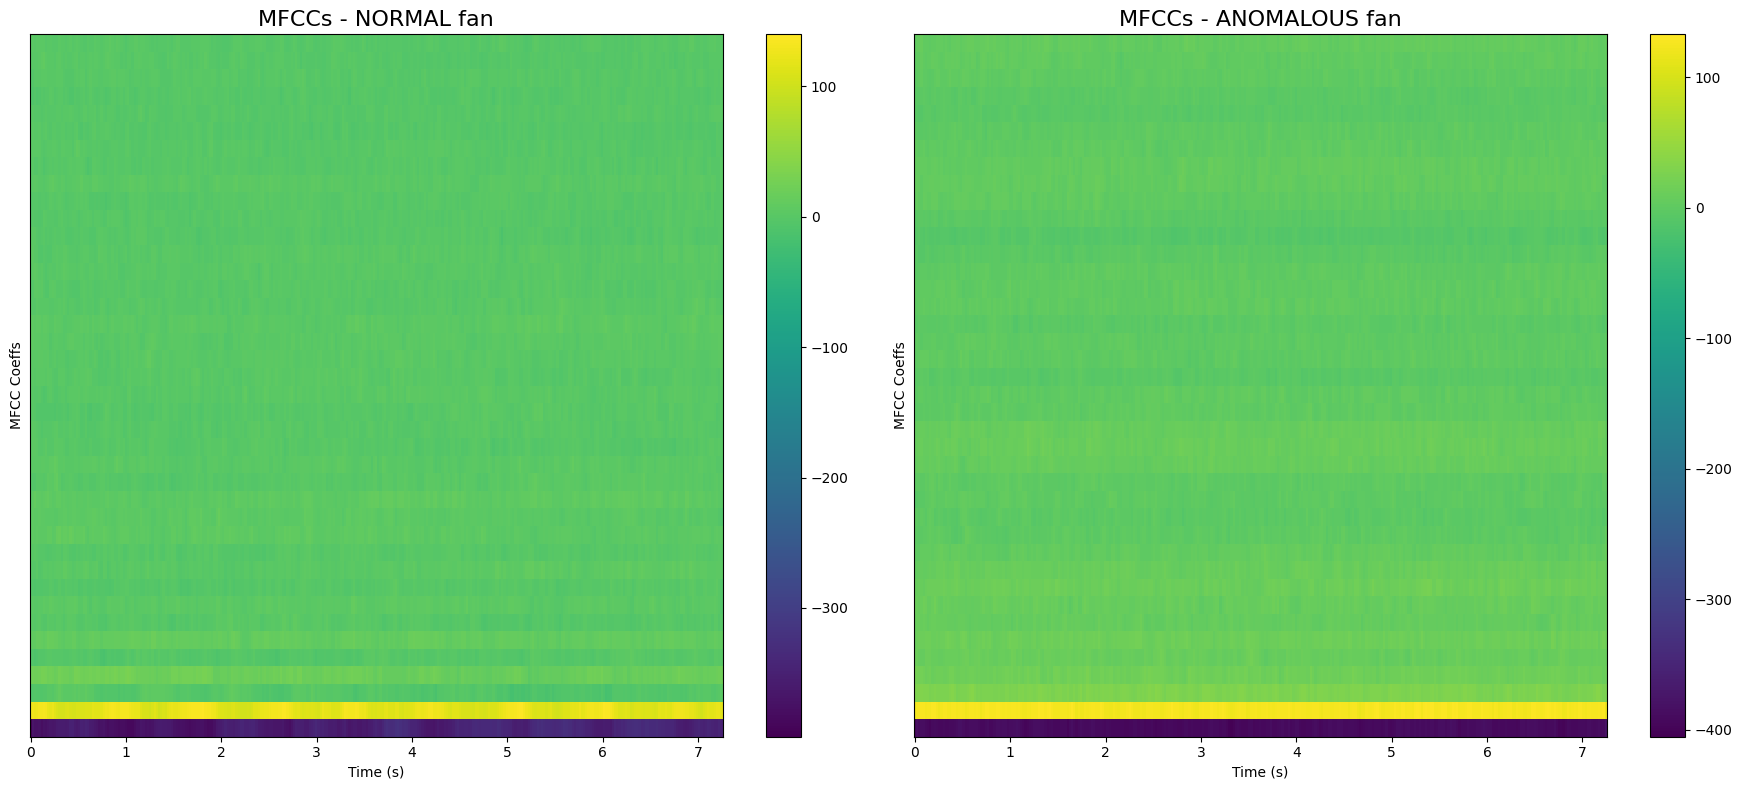

In [24]:
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Calculate MFCCs for normal audio
mfccs_normal = librosa.feature.mfcc(y=y_normal, sr=sr, n_mfcc=40)

# Calculate MFCCs for anomalous audio
mfccs_anom = librosa.feature.mfcc(y=y_anom, sr=sr, n_mfcc=40)

# Plotting MFCCs side-by-side
plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
librosa.display.specshow(mfccs_normal, x_axis='time', cmap='viridis')
plt.colorbar()
plt.title('MFCCs - NORMAL fan', fontsize=16)
plt.xlabel('Time (s)')
plt.ylabel('MFCC Coeffs')

plt.subplot(1, 2, 2)
librosa.display.specshow(mfccs_anom, x_axis='time', cmap='viridis')
plt.colorbar()
plt.title('MFCCs - ANOMALOUS fan', fontsize=16)
plt.xlabel('Time (s)')
plt.ylabel('MFCC Coeffs')

plt.tight_layout()
plt.show()


### Interpreting the MFCC Plots

Mel-Frequency Cepstral Coefficients (MFCCs) are a representation of the short-term power spectrum of a sound. They are derived from the Mel spectrogram but are further processed to decorrelate the features and compress the information, focusing on the perceptually important aspects of sound.

### General Observations:

*   **Y-axis**: Represents the MFCC coefficients (from 0 up to `n_mfcc-1`, which is 39 in this case). Lower coefficients generally represent broader spectral characteristics, while higher coefficients capture finer details.
*   **X-axis**: Represents time, similar to the spectrograms.
*   **Color**: Indicates the amplitude of the MFCC coefficients, often corresponding to the energy distribution in different frequency bands.

### Comparison between NORMAL and ANOMALOUS MFCCs:
#### MFCCs - NORMAL fan
The plot is dominated by a consistent, uniform green-yellow color across all time and the mid-to-high MFCC coefficients.
This indicates that the spectral characteristics (the distribution of energy across different frequency bands and their modulation) are stable and consistent throughout the 7-second duration.
The lack of significant variation in the mid-to-high coefficients (the bulk of the plot) suggests a steady, repetitive, and characteristic sound of a fan operating normally.
#### MFCCs - ANOMALOUS fan
Similar to the normal plot, the anomalous plot is largely dominated by the green-yellow color, showing the underlying fan sound is still present.
However, compared to the normal plot, the anomalous plot appears to have subtle, but visible, variations or vertical stripes in the green area, particularly in the middle to upper MFCC coefficients. These vertical variations are small, short, and slightly darker (more green than yellow-green) than the background.
This suggests momentary changes or instability in the fan's spectral envelope over time. These small fluctuations can correspond to slight speed variations, temporary rubbing, an intermittent knock, or a change in the airflow caused by a developing mechanical issue.

# Third task : Preprocessing

### What we do in the preprocessing step

we prepare all the Fan audio files so the Transformer model can understand them easily.  

First,after loading  each 10-second .wav file we  make sure it uses a sampling rate of 16,000 Hz and only one channel (mono).  

Then, we convert the audio into a log-Mel spectrogram with 128 frequency bands, which turns the sound into a clear 2D image where time goes from left to right and frequency goes from bottom to top.  

Finally, we apply a logarithm to balance loud and quiet parts, and we normalize the values so the average is 0 and the standard deviation is 1.  

This gives us a clean, ready-to-use image for every audio file. All modern Transformer models, such as AST or BEATs, were trained exactly this way, so our model will learn quickly and perform very well in the next weeks.



**Data Augmentation**[1] (dynamic augmentation)

We will add small random changes to the normal pump sounds during training only:
- A bit of factory noise  =>adding background noise
- Slightly higher or lower pitch => frequency masking  
- Slightly faster or slower speed  => time masking
- A little louder or quieter



[1] Zahedi, E., Saraee, M., Masoumi, F., & Yazdinejad, M. (2023). Regularized Contrastive Masked Autoencoder Model for Machinery Anomaly Detection Using Diffusion-Based Data Augmentation. Algorithms, 16, 431. https://doi.org/10.3390/a16090431.

In [25]:
import torchaudio
from torchaudio.transforms import MelSpectrogram, Resample
import torch

###  fixing the log_mel transformer

In [26]:
mel_transform = MelSpectrogram(
    sample_rate=16000,
    n_fft=400,
    hop_length=160,
    n_mels=128,
    f_min=50,
    f_max=8000,
    normalized=True
)

/usr/local/lib/python3.12/dist-packages/torchaudio/functional/functional.py:582: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


### the preprocessing function

In [27]:
from torchaudio.transforms import MelSpectrogram, Resample, PitchShift, TimeStretch

def load_pump_audio_with_augmentation(filepath, augment=False):
    waveform, sr = torchaudio.load(filepath)

    # 1. Resample to 16kHz + mono
    if sr != 16000:
        waveform = Resample(sr, 16000)(waveform)
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)  # mono


    if augment:
        # Pitch shift (2 semitones)  "pitch"
        if random.random() > 0.5:
            pitch = PitchShift(sample_rate=16000, n_steps=random.randint(-2, 2))
            waveform = pitch(waveform)

        # Speed change 92–108% → "vitesse"
        if random.random() > 0.5:
            rate = random.uniform(0.92, 1.08)
            # Simple & safe speed change by resampling back and forth
            temp = Resample(16000, int(16000 * rate))(waveform)
            waveform = Resample(int(16000 * rate), 16000)(temp)

        # Add background nouse
        if random.random() > 0.5:
            noise = torch.randn_like(waveform) * random.uniform(0.003, 0.01)
            waveform = waveform + noise
            waveform = waveform.clamp(-1, 1)  # prevent clipping

    # 3. Mel spectrogram to log to normalize
    spec =mel_transform(waveform)                          # (1, 128, T)
    spec = torch.log(spec + 1e-9)
    spec = (spec - spec.mean()) / (spec.std() + 1e-9)

    return spec.squeeze(0)

In [32]:
! pip install torchcodec

### testing the function (augmenataion part)

In [33]:


spec1 = load_pump_audio_with_augmentation(normal_file, augment=True)
spec2 = load_pump_audio_with_augmentation(normal_file, augment=True)
spec_clean = load_pump_audio_with_augmentation(normal_file, augment=False)

print("Shape clean   :", spec_clean.shape)
print("Shape aug 1   :", spec1.shape)
print("Shape aug 2   :", spec2.shape)
print("difference", not torch.allclose(spec1, spec2))


AttributeError: partially initialized module 'torch._dynamo' has no attribute 'guards' (most likely due to a circular import)

In [ ]:
plt.figure(figsize=(18,10))

plt.subplot(2,1,1)
librosa.display.specshow(spec_clean.numpy(), sr=16000, hop_length=160, x_axis='time', y_axis='mel', cmap='magma')
plt.title("1. Original normal pump – clean", fontsize=16)
plt.colorbar(format='%+2.0f dB')

plt.subplot(2,1,2)
librosa.display.specshow(spec1.numpy(), sr=16000, hop_length=160, x_axis='time', y_axis='mel', cmap='magma')
plt.title("2. Augmented version 1 (noise + speed + pitch) ", fontsize=16)
plt.colorbar(format='%+2.0f dB')


plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined